In [11]:
%load_ext rpy2.ipython
import numpy as np
import pandas as pd
import os
import h5py

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


We can use the filenames from the MinION to generate
some interesting statistics about our run!

The first thing we'll do is test to see if the QC held true.
If the initial QC says 1041 pores, then how many of those actually
produce at least one viable sequence?


In [12]:
PASS_DIR = "/mnt/shared/PoreCampAU/data/fast5/e_coli_R9/"
MY_MUX_DIR = "my_mux_data/"

if not os.path.isdir(MUX_DIR):
    os.mkdir(MUX_DIR)
    
fast5_files = [PASS_DIR + fast5_file for fast5_file in os.listdir(PASS_DIR)
              if fast5_file.endswith(".fast5")]

# We will now write to file for each fastfile, the channel id, and the mux id.
mux_file = MY_MUX_DIR + "e_coli_R7.3.mux.txt"
mux_handle = open(mux_file, 'w')

for fast5file in fast5_files:
    channel = fast5file.split('_')[-3]  # 'channel_512'
    channel_num = channel.replace('ch', "")  # '512'
    read = fast5file.split('_')[-2]  # 'read_23042'
    read_num = read.replace("read", "")  # '23042'
    # Open fast5 file
    f = h5py.File(fast5file, 'r')
    mux_path = "/Raw/Reads/Read_" + str(read_num)
    mux = f[mux_path].attrs.values()[2]
    mux_handle.write(channel_num + "\t" + str(mux) + "\n")

mux_handle.close()  # Don't forget to close the gate or all your bytes will escape!

The list that we import has as many rows as we have fast5 files, and two columns.
The first column is the channel id, the second is the mux id.
Open up the mux file to get a better look. It will only be 100 lines long as we only have 100 reads
in this folder. For your benefit I have a similar text file using all the pass reads from a run.

In [13]:
SHARED_MUX_DIRECTORY = "/mnt/shared/PoreCampAU/data/mux_counts/"
# List files in the mux directory that we can play with
mux_files = [mux_file for mux_file in os.listdir(SHARED_MUX_DIRECTORY)]
print '\n'.join(mux_files)

e_coli_R9.mux.txt
e_coli_R7.3.mux.txt
e_coli_R9.4.mux.txt


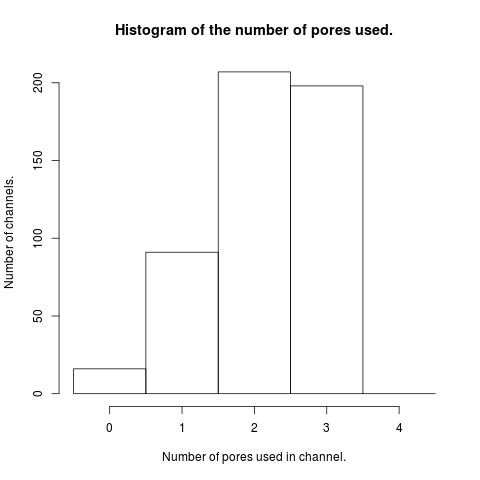

In [16]:
%%R -i SHARED_MUX_DIRECTORY,MY_MUX_DIR -o mux_table,mux_stats

# copy and paste one of the mux files printed above into to quotation marks below.
mux_file = paste(SHARED_MUX_DIRECTORY, "e_coli_R9.4.mux.txt", sep="/") 

mux_data <- read.table(mux_file, header=FALSE, sep="\t")
names(mux_data) <- c("channel", "mux")
mux_data$channel = factor(mux_data$channel, levels=c(1:512))

THRESHOLD = 1;  # How many pass reads need to pass through the pore
                # to consider this a pass read.
    
total_viable_pores = 0;  # Initialise value then increment.

mux_per_channel = NULL  # array which we will append to then summarise
                      # for each channel. Will be given the number
                      # 0:4 for a given channel.
        
reads_per_pore = NULL  # for each pore a value of the number of reads
                          # produced by this channel.

mux_table <- as.matrix(table(mux_data$channel, mux_data$mux))

for(channel in 1:512){
    mux_in_this_channel = sum(mux_table[channel, ] > THRESHOLD)  # number between 0 and 4.
    mux_per_channel = c(mux_per_channel, mux_in_this_channel)
}


# Create a histogram using the mux_per_channel variable.
breaks = seq(-0.5, 4.5, by = 1)
xlab = "Number of pores used in channel."
ylab = "Number of channels."
main = "Histogram of the number of pores used."
hist(mux_per_channel, breaks=breaks,
    xlab=xlab, ylab=ylab, main=main)

# Save plot using cairo
plot_name = paste(MY_MUX_DIR, "e_coli_R7.3.png", sep="/")
png(plot_name, type="cairo")
hist(mux_per_channel, breaks=breaks,
    xlab=xlab, ylab=ylab, main=main)
dev.off()

# Create a log histogram of the number of pass reads
# each channel produced.

mux_stats = table(mux_per_channel)  # Return this value so we can print
# mux_stats will produce a 
# a final QC using python.

In [17]:
# Use the output from R to mimic the initial QC stage.
# How does this plot compare to the initial QC you performed.
for i in range(0,5):
    try:
        print "The number of channels with %d viable pores: %d" % (i, mux_stats[i])
    except IndexError:
        print("No channels present with %d viable pores" % i)

The number of channels with 0 viable pores: 16
The number of channels with 1 viable pores: 91
The number of channels with 2 viable pores: 207
The number of channels with 3 viable pores: 198
No channels present with 4 viable pores


#### Examining half lives:
So now we know how many pores in a flowcells actually produced reads.
But of those that produced reads, how many reads did they produce?
A really cool plot to create is to build a half life plot of the reads.
This can also be useful for run diagnostics, good DNA generally allows a pore to last longer ==>
more reads can go through the pore. Poor DNA can clog up a pore and we should see a much steeper slope in the number of reads each pore produces.

In this next plot we should see a nice logarithmic curve showing the half-life of pores.


png 
  2 


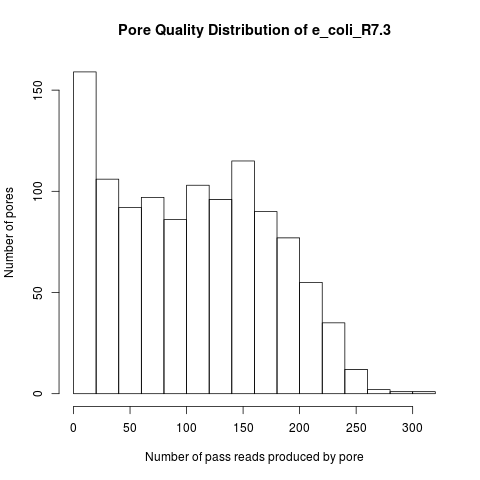

In [20]:
%%R -i mux_table,MY_MUX_DIR

# Given we're wanting to see the longevity of a pore, we'll take out those pores
# that did not produce at least one read.
mux_table <- mux_table[which(mux_table != 0)]

run_name = "e_coli_R7.3"
plot_filename = paste(MY_MUX_DIR, run_name, ".pore_durability.png", sep="")

# Create the plot below and also print it to file
hist(mux_table,  main = paste("Pore Quality Distribution of", run_name),
        xlab = "Number of pass reads produced by pore", ylab = "Number of pores")

png(plot_filename, type = "cairo")
hist(mux_table,  main = paste("Pore Quality Distribution of", run_name),
        xlab = "Number of pass reads produced by pore", ylab = "Number of pores")
dev.off()